<a href="https://www.kaggle.com/code/xpertdl/class24-25-26-27?scriptVersionId=298487345" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm


In [2]:
cat_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat"
dog_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog"

In [3]:
IMG_SIZE = 64
SAMPLES_PER_CLASS = 250
random.seed(42)

In [4]:
classes = {
    cat_path: 0,
    dog_path: 1
}

X = []
y = []

In [5]:
for class_path, label in classes.items():
    all_images = os.listdir(class_path)
    random.shuffle(all_images)

    count = 0

    for img_name in tqdm(all_images, desc=f"Processing {class_path.split('/')[-1]}"):
        if count >= SAMPLES_PER_CLASS:
            break

        img_path = os.path.join(class_path, img_name)

        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize((IMG_SIZE, IMG_SIZE))

            img_array = np.array(img, dtype=np.float32) / 255.0

            X.append(img_array)
            y.append(label)

            count += 1

        except:
            continue

X = np.array(X)          
y = np.array(y)




Processing Dog:   2%|▏         | 250/12501 [00:07<05:58, 34.15it/s]


In [6]:
indices = np.arange(len(X))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

In [7]:
X = np.transpose(X, (0, 3, 1, 2))
y = y.reshape(-1, 1)

print("X shape:", X.shape)  
print("y shape:", y.shape)  


X shape: (500, 3, 64, 64)
y shape: (500, 1)


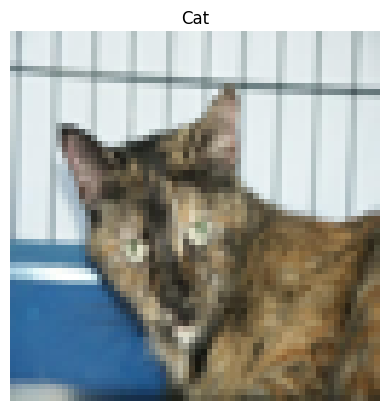

In [8]:
import matplotlib.pyplot as plt


i = np.random.randint(0, len(X))
img = X[i].transpose(1, 2, 0)

plt.imshow(img)
plt.title("Dog" if y[i] == 1 else "Cat")
plt.axis("off")
plt.show()


In [ ]:

plt.figure(figsize=(10, 5))

for i in range(8):
    plt.subplot(2, 4, i + 1)

    img = X[i].transpose(1, 2, 0)
    plt.imshow(img)

    plt.title("Dog" if y[i] == 1 else "Cat")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
class ReLU:
  def __init__(self,):
    pass
  def forward(self, z):
    self.input_ = z
    return np.maximum(z, 0)

  def backward(self, delta):
    return delta * (self.input_ > 0).astype(int)


class Sigmoid:
  def __init__(self,):
    pass

  def forward(self, z):
    self.o =  1 / (1+ np.exp(-z))
    return self.o

  def backward(self, delta):
    return self.o * (1 - self. o)



def padding(x, pad):
    if pad == 0:
        return x
    return np.pad(x, ((0, 0), (pad, pad), (pad, pad)), mode="constant")



def BCELoss(y_hat, y):
  eps = 1e-6
  return - np.mean(y * np.log(y_hat +eps) + (1-y) * np.log(1 - y_hat + eps))


[Convolutional opetration](https://drive.google.com/file/d/1hZHd5K68KTeRgBdtOeMlSZgZzLr9-nfO/view?usp=sharing)

In [12]:
class Conv:
    def __init__(self, depth, kernels, kernel_size, stride=1, padding=0, activation="relu"):
        self.weight = np.random.randn(kernels, depth, kernel_size, kernel_size)
        self.bias = np.random.randn(kernels)

        
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.activation = ReLU()


    
    def forward(self, X):
        # X shape: (C, H, W)
        
        X = padding(X, self.padding)
        self.X_padded = X

        C, H, W = X.shape
        
        k = self.kernel_size
        s = self.stride
        
        out_channels = self.weight.shape[0]

        H_out = (H - k) // s + 1
        W_out = (W - k) // s + 1

        out = np.zeros((out_channels, H_out, W_out))
        

        for oc in range(out_channels):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * s
                    w_start = j * s

                    region = X[:, h_start:h_start + k, w_start:w_start + k]

                    
                    out[oc, i, j] = np.sum(region * self.weight[oc]) + self.bias[oc]


        out = self.activation.forward(out)
        return out

    
    def backward(self, delta, lr):
            
            delta = self.activation.backward(delta)
    
            X_padded = self.X_padded
            C, H, W = X_padded.shape
    
            k = self.kernel_size
            s = self.stride
            out_channels, H_out, W_out = delta.shape
    
            dX = np.zeros_like(X_padded)
            dW = np.zeros_like(self.weight)
            db = np.zeros_like(self.bias)
    
            for oc in range(out_channels):
                for i in range(H_out):
                    for j in range(W_out):
    
                        h_start = i * s
                        w_start = j * s
    
                        region = X_padded[:,h_start:h_start+k, w_start:w_start+k]
    
                        # ---- dW ----
                        dW[oc] += region * delta[oc, i, j]
    
                        # ---- db ----
                        db[oc] += delta[oc, i, j]
    
                        # ---- dX ----
                        dX[:, h_start:h_start+k, w_start:w_start+k] += (self.weight[oc] * delta[oc, i, j])
    
            # Here we remove padding from dX
            if self.padding > 0:
                dX = dX[:,
                        self.padding:-self.padding,
                        self.padding:-self.padding]
    
            #  Update rule
            self.weight -= lr * dW
            self.bias -= lr * db
    
            return dX

In [11]:
class MaxPool:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, X):
        self.X = X  # store input for backward
        C, H, W = X.shape
        k = self.kernel_size
        s = self.stride

        H_out = (H - k) // s + 1
        W_out = (W - k) // s + 1

        out = np.zeros((C, H_out, W_out))

        # Cache mask same size as input
        self.cache = np.zeros_like(X)

        for c in range(C):
            for i in range(H_out):
                for j in range(W_out):

                    h_start = i * s
                    w_start = j * s

                    region = X[c,
                               h_start:h_start + k,
                               w_start:w_start + k]

                    # Find max index inside region
                    index = np.argmax(region)
                    row, col = np.unravel_index(index, region.shape)

                    # Store mask at correct location in original input
                    self.cache[c,
                               h_start + row,
                               w_start + col] = 1

                    # Output max value
                    out[c, i, j] = region[row, col]

        return out

    def backward(self, delta, lr):
        
        C, H_out, W_out = delta.shape
        k = self.kernel_size
        s = self.stride

        dX = np.zeros_like(self.X)

        for c in range(C):
            for i in range(H_out):
                for j in range(W_out):

                    h_start = i * s
                    w_start = j * s

                   
                    mask_region = self.cache[c, h_start:h_start + k, w_start:w_start + k]
                    dX[c, h_start:h_start + k, w_start:w_start + k] = ( mask_region * delta[c, i, j])

        return dX

In [13]:
class Flatten:
    def __init__(self):
        pass

    def forward(self, X):
        self.input_shape = X.shape
        out =  X.flatten().reshape(1, -1)
        
        return out

    def backward(self, delta, lr):
        delta = delta.reshape(self.input_shape)
        return delta

In [25]:
class Dense:
  def __init__(self, features, out, activation = "ReLU", last_layer = False):
    self.weights = np.random.randn(out, features)
    self.bias = np.random.randn(1, out)
    self.last_layer = last_layer

    all_activation = {"ReLU": ReLU(), "Sigmoid": Sigmoid()}
    self.activation = all_activation[activation]


  def forward(self, X):
    self.input_ = X
 
    o = X @ self.weights.T + self.bias
    o = self.activation.forward(o)
    return o
    
  def backward(self, delta, lr):
    dl = delta

    if self.last_layer == False:
      dl = self.activation.backward(dl)


    dw = dl.T @ self.input_
    db = np.sum(dl, keepdims=True, axis=0)


    dX =  dl @ self.weights

    self.weights -= lr * dw
    self.bias -= lr * db

    return dX


In [34]:
class CNN:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X):
        x = X
        
        for layer in self.layers:
            x = layer.forward(x)

        return x

    def backward(self, delta, lr):
        dl = delta
        for layer in reversed(self.layers):
          dl = layer.backward(dl, lr)
        

In [35]:
model = CNN([
    Conv(depth=3, kernels=16, kernel_size=3, padding=0),
    MaxPool(2,2),
    Conv(depth=16, kernels=32, kernel_size=3, padding=0),
    MaxPool(2,2),
    Flatten(),
    Dense(6272,64),
    Dense(64,32),
    Dense(32, 1, activation="Sigmoid", last_layer = True),
])


In [30]:
X.shape

(500, 3, 64, 64)

In [36]:
epochs =2
lr = 0.01

for img in range(X.shape[0]):
    for i in range(epochs):
      y_hat = model.forward(X[0])
      loss = BCELoss(y_hat, y[0])
    
      n = X[0].shape[0]
      dl = (y_hat - y[0]) / n
    
    
      model.backward(dl, lr)
    
      print(loss)




/tmp/ipykernel_55/2863260048.py:17: RuntimeWarning: overflow encountered in exp
  self.o =  1 / (1+ np.exp(-z))


13.815510557964274
-9.999994999180668e-07
-9.999994999180668e-07
-9.999994999180668e-07
-9.999994999180668e-07
-9.999994999180668e-07


KeyboardInterrupt: 